# Lecture : Graph Clustering

## Lab 01 : Standard k-means -- Exercise

### Xavier Bresson, Jiaming Wang


In [ ]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2025_codes/codes/03_Graph_Clustering'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    

In [1]:
# Load libraries
import numpy as np
import scipy.io
#%matplotlib notebook 
%matplotlib inline 
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time
import sys; sys.path.insert(0, 'lib/')
from lib.utils import construct_kernel
from lib.utils import compute_kernel_kmeans_EM
from lib.utils import compute_kernel_kmeans_spectral
from lib.utils import compute_purity
from lib.utils import construct_knn_graph
from lib.utils import compute_ncut
from lib.utils import compute_pcut
from lib.utils import graph_laplacian
import warnings; warnings.filterwarnings("ignore")


# Gaussian Mixture Model (GMM)


In [2]:
# Load raw data images
mat = scipy.io.loadmat('datasets/GMM.mat')
X = mat['X']
n = X.shape[0]
d = X.shape[1]
Cgt = mat['Cgt'] - 1; Cgt = Cgt.squeeze()
nc = len(np.unique(Cgt))
print(n,d,nc)


4500 2 9


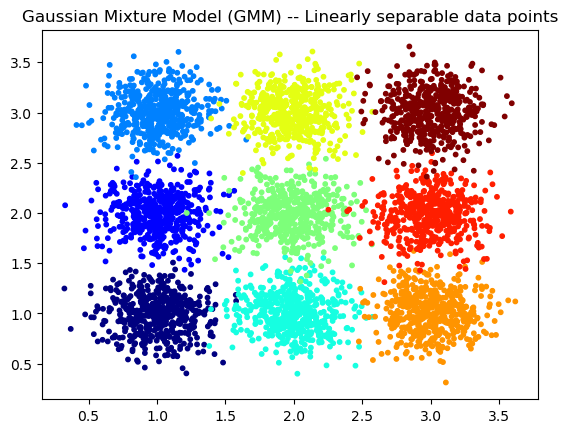

In [3]:
plt.figure(1)
size_vertex_plot = 10
plt.scatter(X[:,0], X[:,1], s=size_vertex_plot*np.ones(n), c=Cgt, cmap='jet')
plt.title('Gaussian Mixture Model (GMM) -- Linearly separable data points')
plt.show()


### Question 1: Evaluating the impact of different initializations on k-Means performance

**Initialization Methods:**
* **Constant Function:** You can use `numpy.ones()` for this initialization.
* **Random Function:** Consider `numpy.random.randint()` for random initialization.

Discuss how these initialization methods affect the clustering results on the distribution of a Gaussian Mixture Model.


In [7]:
# Initialization
n = X.shape[0]
# C_kmeans = np.ones(n) # YOUR CODE HERE
C_kmeans = np.ones(shape=n) # constant initialization
C_kmeans = np.random.randint(nc,size=n) # random initialization

# Linear Kernel for standard K-Means
Ker = X.dot(X.T)
print(Ker.shape)

# Loop
Cold = np.ones([n])
diffC = 1e10
Theta = np.ones(n) # Same weight for each data
Theta = np.diag(Theta)
Ones = np.ones((1,n))
En_iters = []
Clusters_iters = []; Clusters_iters.append(C_kmeans)
k = 0
while (k<50) & (diffC>1e-2):
    
    # Update iteration
    k += 1
    #print(k)
    
    # Distance Matrix D
    row = np.array(range(n))
    col = C_kmeans
    data = np.ones(n)
    F = scipy.sparse.csr_matrix((data, (row, col)), shape=(n, nc)).todense()
    O = np.diag( np.array( 1./ (Ones.dot(Theta).dot(F) + 1e-6) ).squeeze() )
    T = Ker.dot(Theta.dot(F.dot(O)))
    D = - 2* T + np.repeat( np.diag(O.dot((F.T).dot(Theta.dot(T))))[None,:] ,n,axis=0)
    #print(D.shape)
    
    # Extract clusters
    C_kmeans = np.array(np.argmin(D,1)).squeeze()
    Clusters_iters.append(C_kmeans)
                
    # L2 difference between two successive cluster configurations
    diffC = np.linalg.norm(C_kmeans-Cold)/np.linalg.norm(Cold)
    Cold = C_kmeans
        
    # K-Means energy
    En = np.multiply( (np.repeat(np.diag(Ker)[:,None],nc,axis=1) + D) , F)
    En_kmeans = np.sum(En)/n
    En_iters.append(En_kmeans)
    
print(k)


(4500, 4500)
12


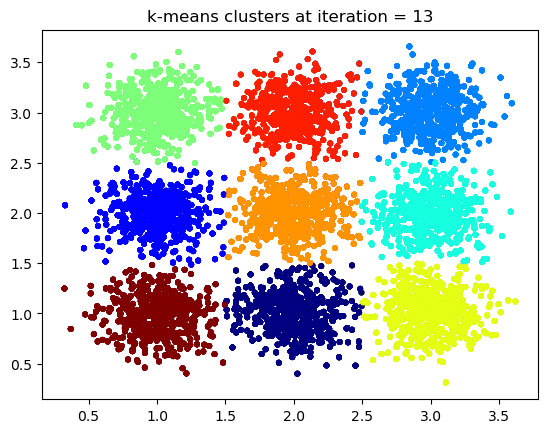

In [8]:
# Visualize k-means iterations
fig, ax = plt.subplots()
for k,C in enumerate(Clusters_iters):
    plt.scatter(X[:,0], X[:,1], s=10*np.ones(n), c=C, cmap='jet')
    plt.title('k-means clusters at iteration = ' + str(k+1) )
    display(fig)
    clear_output(wait=True)


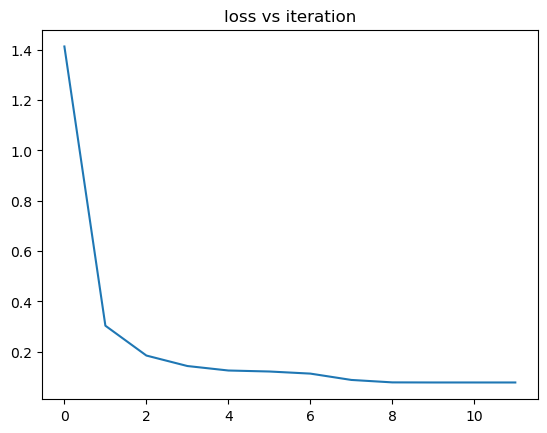

In [9]:
# Visualize loss vs iteration
plt.figure(3)
plt.plot(En_iters)
plt.title('loss vs iteration')
plt.show()


# Two concentric circles


2000 2 2


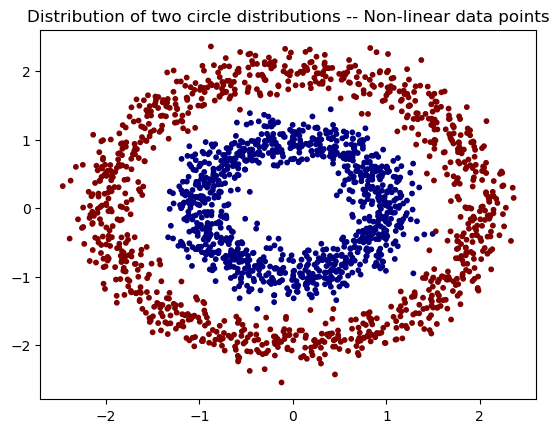

In [10]:
# Load raw data images
mat = scipy.io.loadmat('datasets/two_circles.mat')
X = mat['X']
n = X.shape[0]
d = X.shape[1]
Cgt = mat['Cgt'] - 1; Cgt = Cgt.squeeze()
nc = len(np.unique(Cgt))
print(n,d,nc)

plt.figure(10)
size_vertex_plot = 10
plt.scatter(X[:,0], X[:,1], s=size_vertex_plot*np.ones(n), c=Cgt, cmap='jet')
plt.title('Distribution of two circle distributions -- Non-linear data points')
plt.show()


### Question 2: Assessing k-Means performance with various initializations

Can you identify an initialization function that successfully separates the two classes in this dataset? 

Evaluate the effectiveness of k-means on this dataset.


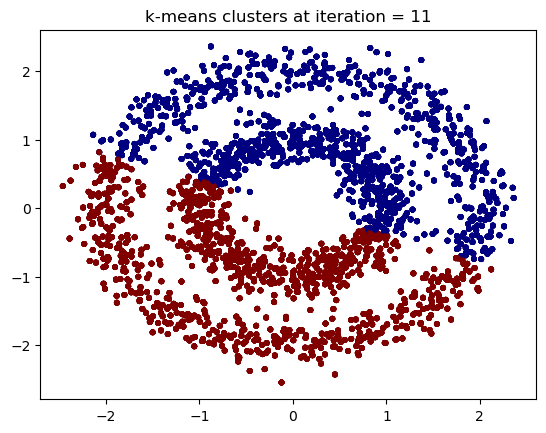

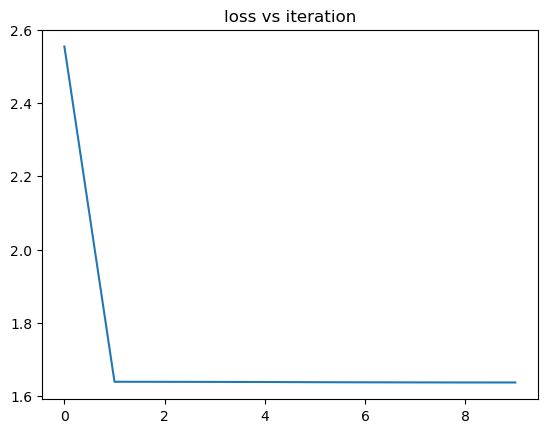

In [11]:
# Initialization
n = X.shape[0]
C_kmeans = np.random.randint(nc,size=n) # random initialization

# Linear Kernel for standard K-Means
Ker = X.dot(X.T)
print(Ker.shape)

# Loop
Cold = np.ones([n])
diffC = 1e10
Theta = np.ones(n) # Equal weight for each data
Theta = np.diag(Theta)
Ones = np.ones((1,n))
En_iters = []
Clusters_iters = []; Clusters_iters.append(C_kmeans)
k = 0
while (k<10) & (diffC>1e-2):
    
    # Update iteration
    k += 1
    #print(k)
    
    # Distance Matrix D
    row = np.array(range(n))
    col = C_kmeans
    data = np.ones(n)
    F = scipy.sparse.csr_matrix((data, (row, col)), shape=(n, nc)).todense()
    O = np.diag( np.array( 1./ (Ones.dot(Theta).dot(F) + 1e-6) ).squeeze() )
    T = Ker.dot(Theta.dot(F.dot(O)))
    D = - 2* T + np.repeat( np.diag(O.dot((F.T).dot(Theta.dot(T))))[None,:] ,n,axis=0)
    #print(D.shape)
    
    # Extract clusters
    C_kmeans = np.array(np.argmin(D,1)).squeeze()
    Clusters_iters.append(C_kmeans)
                
    # L2 difference between two successive cluster configurations
    diffC = np.linalg.norm(C_kmeans-Cold)/np.linalg.norm(Cold)
    Cold = C_kmeans
        
    # K-Means energy
    En = np.multiply( (np.repeat(np.diag(Ker)[:,None],nc,axis=1) + D) , F)
    En_kmeans = np.sum(En)/n
    En_iters.append(En_kmeans)
    
print(k)

# Visualize k-means iterations
fig, ax = plt.subplots()
for k,C in enumerate(Clusters_iters):
    plt.scatter(X[:,0], X[:,1], s=10*np.ones(n), c=C, cmap='jet')
    plt.title('k-means clusters at iteration = ' + str(k+1) )
    display(fig)
    clear_output(wait=True)
    
# Visualize loss vs iteration
plt.figure(12)
plt.plot(En_iters)
plt.title('loss vs iteration')
plt.show()


# Lecture : Graph Clustering

## Lab 02 : Kernel k-means -- Exercise

### Xavier Bresson, Jiaming Wang


In [ ]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2025_codes/codes/03_Graph_Clustering'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    

In [1]:
# Load libraries
import numpy as np
import scipy.io
%matplotlib inline 
import matplotlib.pyplot as plt
import time
import sys; sys.path.insert(0, 'lib/')
from lib.utils import construct_kernel
from lib.utils import compute_kernel_kmeans_EM
from lib.utils import compute_kernel_kmeans_spectral
from lib.utils import compute_purity
from lib.utils import construct_knn_graph
from lib.utils import compute_ncut
from lib.utils import compute_pcut
from lib.utils import graph_laplacian
import warnings; warnings.filterwarnings("ignore")


n,d,nc: 2000 2 2


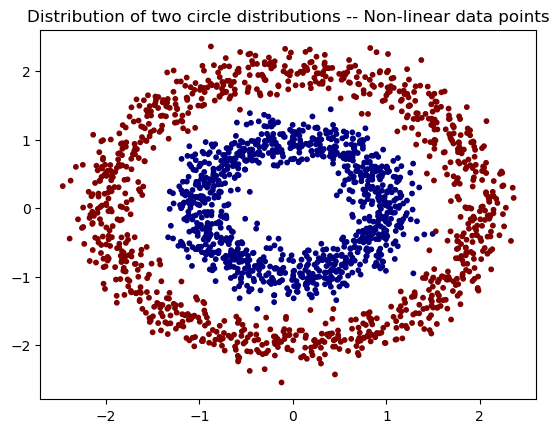

In [2]:
# Load two-circle dataset
mat = scipy.io.loadmat('datasets/two_circles.mat') 
X = mat['X'] # (2000, 2), numpy.ndarray
n = X.shape[0]
d = X.shape[1]
Cgt = mat['Cgt']-1; Cgt = Cgt.squeeze() # (2000,)
nc = len(np.unique(Cgt)) # 2
print('n,d,nc:',n,d,nc)

plt.figure(1)
size_vertex_plot = 10
plt.scatter(X[:,0], X[:,1], s=size_vertex_plot*np.ones(n), c=Cgt, cmap='jet')
plt.title('Distribution of two circle distributions -- Non-linear data points')
plt.show()


### Question 1: Evaluate the performance of *Linear* k-Means using Expectation-Maximization (EM) with multiple random initializations

Use the following code: `compute_kernel_kmeans_EM(nc, Ker, Theta, n_trials)` with the input arguments:

* nc : Number of clusters.
* Ker : Kernel matrix of size n x n, where n is the number of data points.
* Theta : Weight matrix of size n x n, typically a diagonal matrix with the weights of each data point.
* n_trials : Number of runs for kernel k-means. The function returns the solution with the minimum final energy.

How many runs are necessary to obtain the correct solution?


Construct Linear Kernel
(2000, 2000)


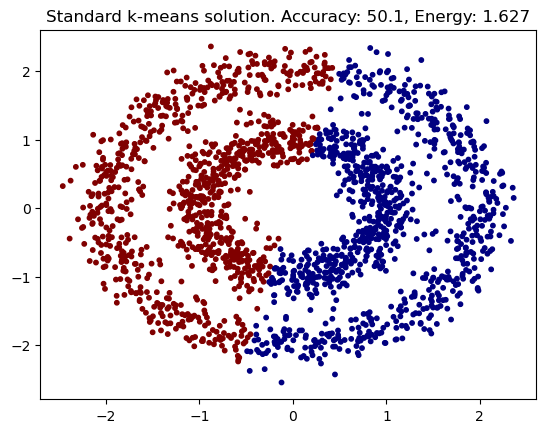

In [7]:
# Run standard/linear k-means
Theta = np.ones(n) # Same weight for all data

# Compute linear kernel for standard k-means
Ker = construct_kernel(X, 'linear') # (2000, 2000)
print(Ker.shape)

# standard k-means
n_trials = 10
C_kmeans, En_kmeans = compute_kernel_kmeans_EM(nc=nc, Ker=Ker, Theta=Theta, nb_trials=n_trials)

# Plot
plt.figure(2)

size_vertex_plot = 10
plt.scatter(X[:,0], X[:,1], s=size_vertex_plot*np.ones(n), c=C_kmeans, cmap='jet')
plt.title('Standard k-means solution. Accuracy: ' + str(compute_purity(C_kmeans,Cgt,nc))[:5] +
         ', Energy: ' + str(En_kmeans)[:5])
plt.show()


### Question 2: Evaluate the performance of *Non-Linear* k-Means using EM with multiple random initializations

How many runs are necessary to achieve the correct solution?


Construct kNN Gaussian Kernel
(2000, 2000)


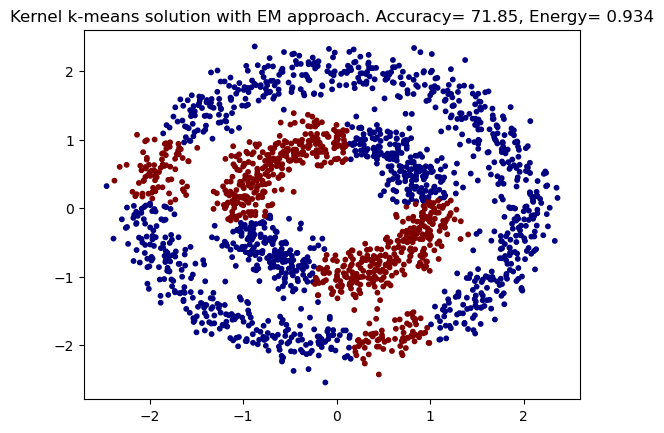

In [8]:
# Run kernel/non-linear k-means with EM approach
 
# Compute linear Kernel for standard k-means
Ker = construct_kernel(X, 'kNN_gaussian', 100)
print(Ker.shape)

# Kernel k-means with EM approach
n_trials = 10
C_kmeans, En_kmeans = compute_kernel_kmeans_EM(nc, Ker, Theta, n_trials)

# Plot
plt.figure(3)
size_vertex_plot = 10
plt.scatter(X[:,0], X[:,1], s=size_vertex_plot*np.ones(n), c=C_kmeans, cmap='jet')
plt.title('Kernel k-means solution with EM approach. Accuracy= ' + str(compute_purity(C_kmeans,Cgt,nc))[:5] +
         ', Energy= ' + str(En_kmeans)[:5])
plt.show()


### Question 3: Evaluate the performance of *Non-Linear* k-Means using the Spectral technique

Use the function `compute_kernel_kmeans_spectral(nc, Ker, Theta)` with the following input arguments:
* nc : Number of clusters.
* Ker : Kernel matrix of size n x n, where n is the number of data points.
* Theta : Weight matrix of size n x n, a diagonal matrix containing the weights of each data point.

Note that this function does not have an `n_trials` input argument. Why do you think that is?


Construct kNN Gaussian Kernel
(2000, 2000)
Construct Linear Kernel


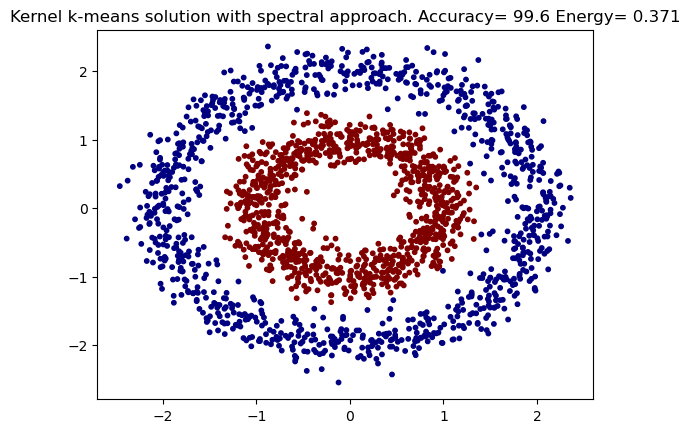

In [9]:
# Run kernel/non-linear k-means with spectral approach
 
# Compute linear kernel for standard k-means
Ker = construct_kernel(X, 'kNN_gaussian', 100)
print(Ker.shape)

# Kernel k-means with spectral approach
C_kmeans, En_kmeans = compute_kernel_kmeans_spectral(nc, Ker, Theta) # YOUR CODE HERE )

# Plot
plt.figure(4)
size_vertex_plot = 10
plt.scatter(X[:,0], X[:,1], s=size_vertex_plot*np.ones(n), c=C_kmeans, cmap='jet')
plt.title('Kernel k-means solution with spectral approach. Accuracy= ' + 
          str(compute_purity(C_kmeans,Cgt,nc))[:5] + ' Energy= ' + str(En_kmeans)[:5])
plt.show()


# Lecture : Graph Clustering

## Lab 03 : Metis -- Exercise

### Xavier Bresson, Jiaming Wang


In [ ]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2025_codes/codes/03_Graph_Clustering'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pip install pymetis==2023.1 # install metis 
    !pip install dgl==2.0.0 -f https://data.dgl.ai/wheels/repo.html # install dgl
    !pwd
    

In [ ]:
# Data conversion used in this notebook
#  from DGL to networkx :                          G_nx = dgl.to_networkx(G_dgl)
#  from scipy.sparse._csc.csc_matrix to DGL :      G_dgl = dgl.from_scipy(G_sp)
#  from scipy.sparse._csc.csc_matrix to networkx : G_nx = nx.from_scipy_sparse_array(G_sp)
#  from networkx to numpy :                        G_np = nx.to_numpy_array(G_nx)


In [1]:
# Load libraries
import numpy as np
import scipy.io
%matplotlib inline
#%matplotlib notebook 
from matplotlib import pyplot
import matplotlib.pyplot as plt
import time
import sys; sys.path.insert(0, 'lib/')
from lib.utils import compute_purity
import warnings; warnings.filterwarnings("ignore")
from lib.utils import nldr_visualization
import os
import torch
import networkx as nx
import time
import dgl # DGL
import pymetis # PyG Metis
import platform


DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


# Artifical balanced graph

### Question 1: Construct a simple graph using the DGL library
Reference: https://www.dgl.ai

Create a graph with 9 nodes indexed from 0 to 8.

The set of edges is defined as E = \{ (0,2), (0,1), (1,2), (3,4), (3, 5), (4,5), (6,7), (6,8), (7,8), (1,7), (2,3) \}.

To construct this graph in DGL, you can use the `dgl.graph()` function:
https://docs.dgl.ai/generated/dgl.graph.html#dgl-graph

For a simple example, see also: https://docs.dgl.ai/en/0.2.x/tutorials/basics/1_first.html#step-1-creating-a-graph-in-dgl

Since the graph is undirected, DGL requires that you add both directions for each edge, e.g. (0,2) and (2,0).

To automatically create an undirected graph from a directed one, you may use the `dgl.add_reverse_edges()` function.


In [5]:
edges.shape

torch.Size([10, 2])

Graph(num_nodes=9, num_edges=22,
      ndata_schemes={}
      edata_schemes={})
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])
(tensor([0, 0, 1, 3, 3, 4, 6, 6, 7, 1, 2, 2, 1, 2, 4, 5, 5, 7, 8, 8, 7, 3]), tensor([2, 1, 2, 4, 5, 5, 7, 8, 8, 7, 3, 0, 0, 1, 3, 3, 4, 6, 6, 7, 1, 2]))


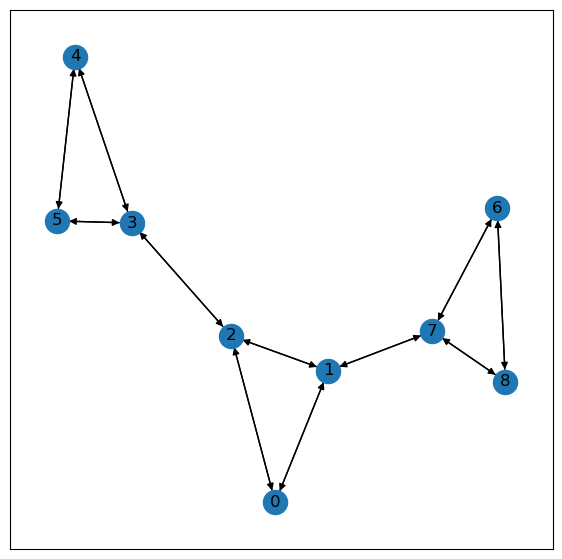

In [7]:
# Build a simple artificail graph of 3 balanced communities with DGL
edges = torch.Tensor(((0,2), (0,1), (1,2), (3,4), (3, 5), (4,5), (6,7), (6,8), (7,8), (1,7), (2,3))).long()
r = edges[:, 0]
c = edges[:, 1]
# Or hardcode the edges as below
# r = torch.LongTensor([0,0,1,3,3,4,6,6,7,1,2])
# c = torch.LongTensor([2,1,2,4,5,5,7,8,8,7,3])
n = 9
G_dgl = dgl.graph((r, c), num_nodes=n)
G_dgl = dgl.add_reverse_edges(G_dgl) # undirected graph
print(G_dgl)
print(G_dgl.nodes())
print(G_dgl.edges())

# Plot graph
G_nx = dgl.to_networkx(G_dgl)
plt.figure(figsize=[7,7])
nx.draw_networkx(G_nx, with_labels=True)


### Question 2: Partition the artificial graph using Metis

Metis is accessible through the PyMetis package:  
https://pypi.org/project/PyMetis

Experiment with different numbers of partitions to see how the graph is divided.


C_metis_pyg tensor([1, 1, 1, 0, 0, 0, 2, 2, 2])


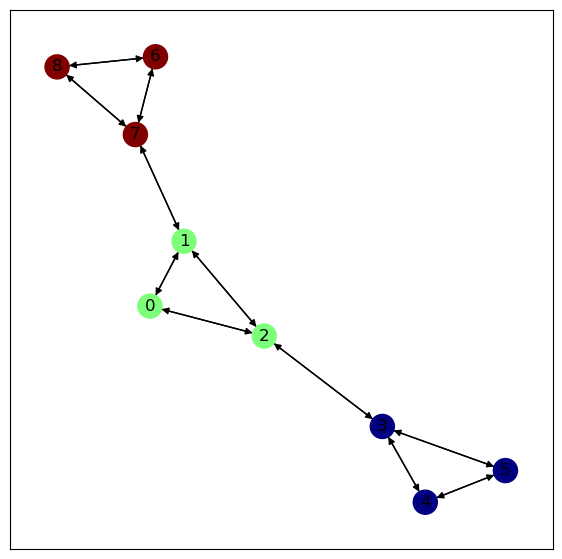

In [10]:
# Run Metis with PyMetis
num_parts = 3
G_nx = dgl.to_networkx(G_dgl)
_, part_vert = pymetis.part_graph(num_parts, G_nx) # YOUR CODE HERE 
C_metis_pyg = torch.tensor(part_vert).long()
print('C_metis_pyg',C_metis_pyg)
plt.figure(figsize=[7,7])
nx.draw_networkx(G_nx, with_labels=True, node_color=C_metis_pyg, cmap='jet')


In [12]:
# Run Metis with DGL
#  https://docs.dgl.ai/en/0.8.x/generated/dgl.dataloading.ClusterGCNSampler.html

if platform.system()!='Windows': # os is not Windows
    try: os.remove("cluster_gcn.pkl") # remove any existing partition
    except: print("error in deleting existing partition") 
    num_parts = 3
    sampler = dgl.dataloading.ClusterGCNSampler(G_dgl, num_parts) 
    C_metis_dgl = torch.zeros(G_dgl.num_nodes()).long()
    for idx, (idx_start, idx_end) in enumerate(zip(sampler.partition_offset[:num_parts], sampler.partition_offset[1:num_parts+1])):
        C_metis_dgl[sampler.partition_node_ids[idx_start: idx_end]] = idx
    print('C_metis_dgl',C_metis_dgl)
    G_nx = dgl.to_networkx(G_dgl)
    plt.figure(figsize=[7,7])
    nx.draw_networkx(G_nx, with_labels=True, node_color=C_metis_dgl, cmap='jet')
else:
    print('DGL has not yet implemented Metis under Windows.')
    

DGL has not yet implemented Metis under Windows.


# Real-world USPS image graph

In [14]:
# Load USPS Music dataset
mat = scipy.io.loadmat('datasets/USPS.mat')
W = mat['W'] # scipy.sparse._csc.csc_matrix
n = W.shape[0]
Cgt = mat['Cgt']-1; Cgt = Cgt.squeeze()
nc = len(np.unique(Cgt))
print('n,nc:',n,nc, W.shape)


n,nc: 9298 10 (9298, 9298)


### Question 3: Partition the real-world USPS image graph using Metis
https://datasets.activeloop.ai/docs/ml/datasets/usps-dataset

After partitioning the graph using Metis, visualize it with clusters represented by different colors.

Do the resulting clusters reveal any meaningful patterns?


In [15]:
# Run Metis with PyMetis
num_parts = nc
G_nx = nx.from_scipy_sparse_array(W)
start = time.time()
_, part_vert = pymetis.part_graph(num_parts, G_nx) # YOUR CODE HERE 
print('Time(sec) : %.3f' % (time.time()-start) )
C_metis_pyg = np.array(part_vert,dtype='int32')
acc = compute_purity(C_metis_pyg, Cgt, nc)
print('\nAccuracy Metis PyG :',acc)


Time(sec) : 0.062

Accuracy Metis PyG : 77.94149279414928


In [17]:
# Run Metis with DGL
#  https://docs.dgl.ai/en/0.8.x/generated/dgl.dataloading.ClusterGCNSampler.html

# windows not support metis in DGL
if platform.system()!='Windows': # os is not Windows
    try: os.remove("cluster_gcn.pkl") # remove any existing partition
    except: pass 
    num_parts = nc
    G_dgl = dgl.from_scipy(W)
    start = time.time()
    sampler = dgl.dataloading.ClusterGCNSampler(G_dgl, num_parts) 
    print('Time(sec) : %.3f' % (time.time()-start) )
    C_metis_dgl = torch.zeros(G_dgl.num_nodes()).long()
    for idx, (idx_start, idx_end) in enumerate(zip(sampler.partition_offset[:num_parts], sampler.partition_offset[1:num_parts+1])):
        C_metis_dgl[sampler.partition_node_ids[idx_start: idx_end]] = idx
    print('C_metis_dgl',C_metis_dgl)
    C_metis_dgl = np.array(C_metis_dgl, dtype='int32')
    acc = compute_purity(C_metis_dgl, Cgt, nc)
    print('\nAccuracy Metis DGL :',acc)
else:
    print('DGL has not yet implemented Metis under Windows.')


DGL has not yet implemented Metis under Windows.


Time(sec): 18.853
(9298,)


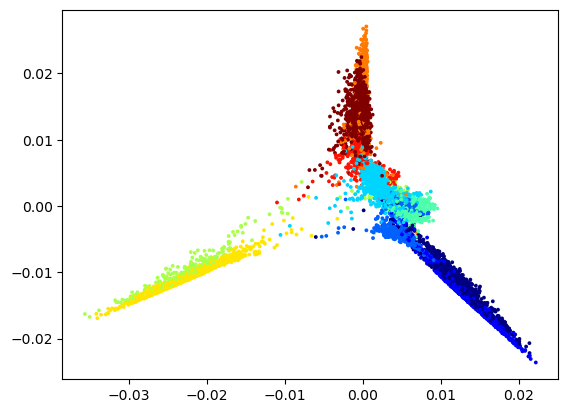

In [18]:
# Compute non-linear dim reduction
start = time.time()
[X,Y,Z] = nldr_visualization(nx.to_numpy_array(G_nx))
print('Time(sec): %.3f' % (time.time()-start) )
print(X.shape)

# 2D Visualization
plt.figure(3)
plt.scatter(X, Y, c=C_metis_pyg, s=3, color=pyplot.jet())
plt.show()


In [ ]:
# 3D Visualization
import plotly.graph_objects as go
data = go.Scatter3d(x=X, y=Y, z=Z, mode='markers', marker=dict(size=1, color=C_metis_pyg, colorscale='jet', opacity=1)) # data as points
# data = go.Scatter3d(x=Xvis, y=Yvis, z=Zvis, mode='markers', marker=dict(size=1, color=C, colorscale='jet', opacity=1, showscale=True)) # w/ colobar 
fig = go.Figure(data=[data]) 
fig.update_layout(margin=dict(l=0, r=0, b=0, t=30, pad=0)) # tight layout but t=25 required for showing title 
fig.update_layout(autosize=False, width=600, height=600, title_text="3D visualization of USPS image graph") # figure size and title
# fig.update_layout(scene = dict(xaxis = dict(visible=False), yaxis = dict(visible=False), zaxis = dict(visible=False))) # no grid, no axis 
# fig.update_layout(scene = dict(xaxis_title = ' ', yaxis_title = ' ', zaxis_title = ' ')) # no axis name 
fig.update_layout(scene = dict(zaxis = dict(showgrid = True, showticklabels = False), zaxis_title = ' ') ) # no range values, no axis name, grid on
fig.update_layout(scene = dict(yaxis = dict(showgrid = True, showticklabels = False), yaxis_title = ' ') ) # no range values, no axis name, grid on
fig.update_layout(scene = dict(xaxis = dict(showgrid = True, showticklabels = False), xaxis_title = ' ') ) # no range values, no axis name, grid on
fig.layout.scene.aspectratio = {'x':1, 'y':1, 'z':1}
fig.show()


: 

# Lecture : Graph Clustering

## Lab 04 : NCut -- Solution

### Xavier Bresson, Jiaming Wang


In [ ]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2025_codes/codes/03_Graph_Clustering'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    

In [1]:
# Load libraries
import numpy as np
import scipy.io
%matplotlib inline
#%matplotlib notebook 
from matplotlib import pyplot
import matplotlib.pyplot as plt
import time
import sys
sys.path.insert(0, 'lib/')
from lib.utils import construct_kernel
from lib.utils import compute_kernel_kmeans_EM
from lib.utils import compute_kernel_kmeans_spectral
from lib.utils import compute_purity
from lib.utils import construct_knn_graph
from lib.utils import compute_ncut
from lib.utils import compute_pcut
from lib.utils import graph_laplacian
import warnings; warnings.filterwarnings("ignore")


(n,d,nc: 4000 4 4


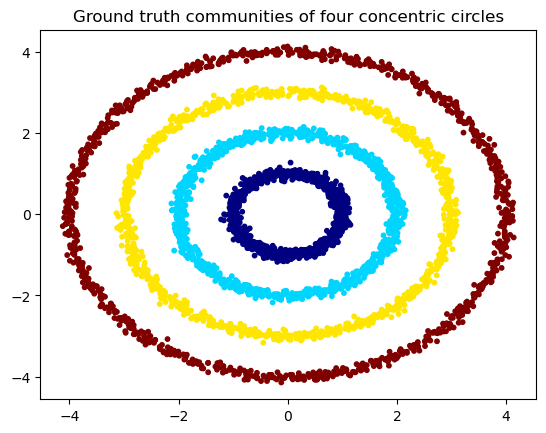

In [2]:
# Load four-circle dataset
mat = scipy.io.loadmat('datasets/four_circles.mat')
X = mat['X']
n = X.shape[0]
d = X.shape[1]
Cgt = mat['Cgt']-1; Cgt=Cgt.squeeze()
nc = len(np.unique(Cgt))
print('(n,d,nc:',n,d,nc)

plt.figure(1)
size_vertex_plot = 10
plt.scatter(X[:,0], X[:,1], s=size_vertex_plot*np.ones(n), c=Cgt, color=pyplot.jet())
plt.title('Ground truth communities of four concentric circles')
plt.show()


Construct Linear Kernel


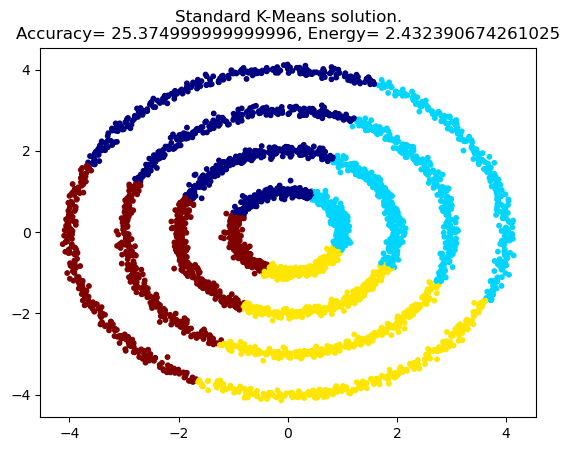

In [3]:
# Run standard/linear k-means with EM approach
Theta = np.ones(n) # Same weight for each data
# Compute linear Kernel for standard K-Means
Ker = construct_kernel(X, 'linear')
# Standard K-Means
C_kmeans, En_kmeans = compute_kernel_kmeans_EM(nc, Ker, Theta, 10)
# Plot
plt.figure(2)
size_vertex_plot = 10
plt.scatter(X[:,0], X[:,1], s=size_vertex_plot*np.ones(n), c=C_kmeans)
plt.title('Standard K-Means solution.\nAccuracy= ' + str(compute_purity(C_kmeans,Cgt,nc)) +
         ', Energy= ' + str(En_kmeans))
plt.show()


Construct kNN Gaussian Kernel
Construct Linear Kernel


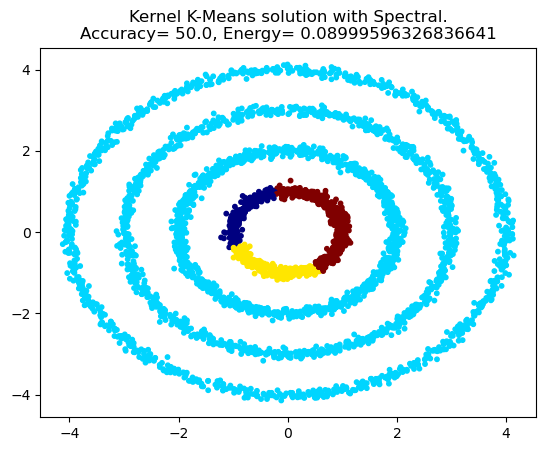

In [4]:
# Run kernel/non-linear k-means with spectral approach
Ker = construct_kernel(X, 'kNN_gaussian', 100)
# Kernel K-Means with Spectral approach
C_kmeans, En_kmeans = compute_kernel_kmeans_spectral(nc, Ker, Theta)
# Plot
plt.figure(3)
size_vertex_plot = 10
plt.scatter(X[:,0], X[:,1], s=size_vertex_plot*np.ones(n), c=C_kmeans, color=pyplot.jet())
plt.title('Kernel K-Means solution with Spectral.\nAccuracy= ' + 
          str(compute_purity(C_kmeans,Cgt,nc)) + ', Energy= ' + str(En_kmeans))
plt.show()


### Question 1: Apply the spectral NCut technique with different k values on the k-NN Graph

Experiment with the following values of k: {5, 10, 20, 40, 80}.

Observe and explain what happens when k is small, resulting in sparse graphs, versus when k is large, leading to densely connected graphs.


k-NN graph with Zelnik-Perona technique


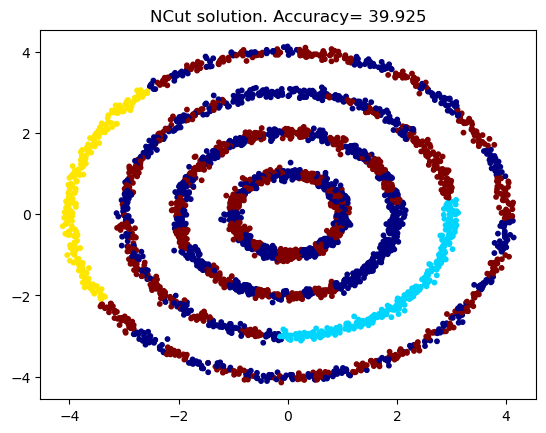

In [5]:
# Run NCut
k = 5 # YOUR CODE HERE 
W = construct_knn_graph(X, k, 'euclidean_zelnik_perona')
C_ncut, acc = compute_ncut(W, Cgt, nc)

# Plot
plt.figure(4)
size_vertex_plot = 10
plt.scatter(X[:,0], X[:,1], s=size_vertex_plot*np.ones(n), c=C_ncut, color=pyplot.jet())
plt.title('NCut solution. Accuracy= ' + 
          str(compute_purity(C_ncut,Cgt,nc)) )
plt.show()


k= 5
k-NN graph with Zelnik-Perona technique


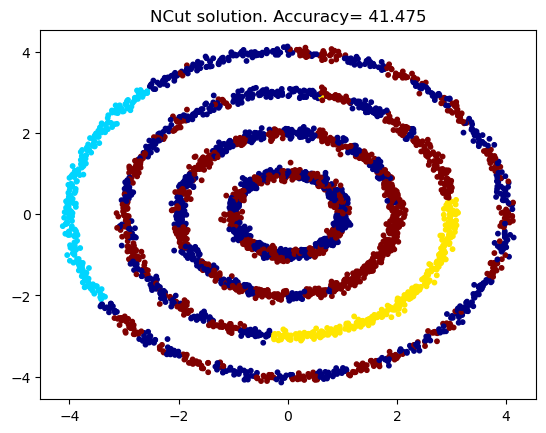

k= 10
k-NN graph with Zelnik-Perona technique


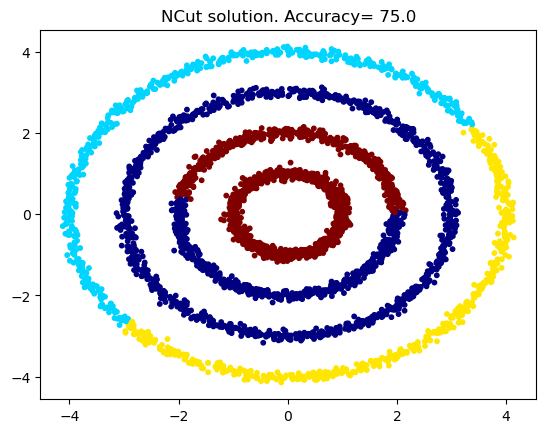

k= 20
k-NN graph with Zelnik-Perona technique


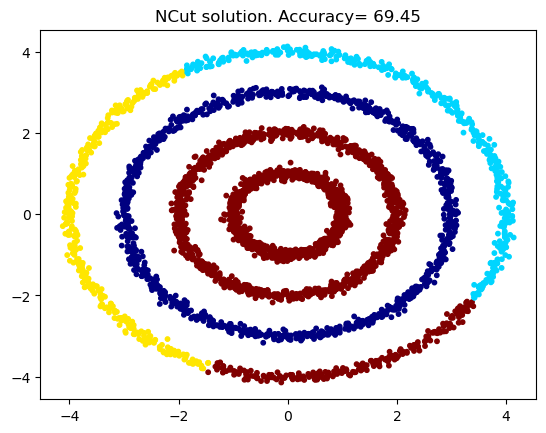

k= 40
k-NN graph with Zelnik-Perona technique


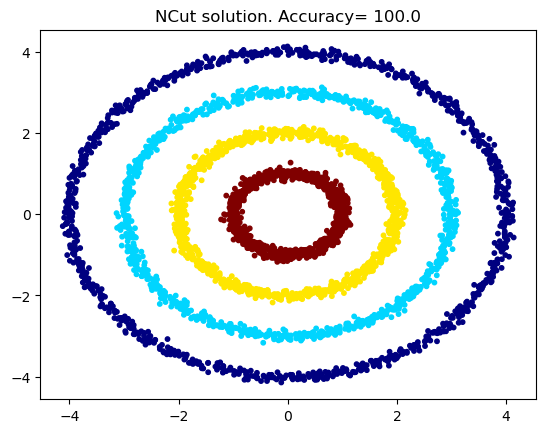

k= 80
k-NN graph with Zelnik-Perona technique


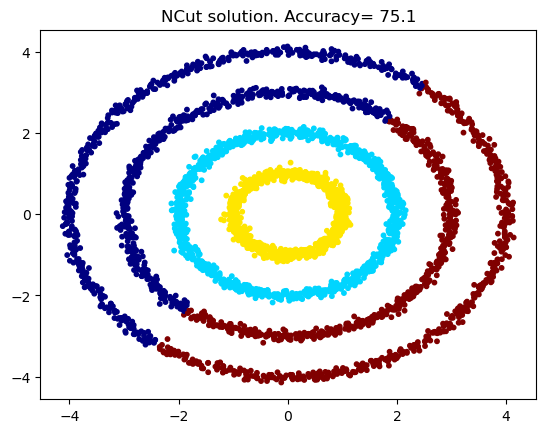

In [7]:
# Run NCut
k_ls = [5,10,20,40,80]
for k in k_ls:
    # k = 5 # YOUR CODE HERE 
    print('k=',k)
    W = construct_knn_graph(X, k, 'euclidean_zelnik_perona')
    C_ncut, acc = compute_ncut(W, Cgt, nc)

    # Plot
    plt.figure(4)
    size_vertex_plot = 10
    plt.scatter(X[:,0], X[:,1], s=size_vertex_plot*np.ones(n), c=C_ncut, color=pyplot.jet())
    plt.title('NCut solution. Accuracy= ' + 
            str(compute_purity(C_ncut,Cgt,nc)) )
    plt.show()

# Lecture : Graph Clustering

## Lab 05 : PCut -- Solution

### Xavier Bresson, Jiaming Wang


In [ ]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2025_codes/codes/03_Graph_Clustering'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    

In [1]:
# Load libraries
import numpy as np
import scipy.io
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
import time
import sys; sys.path.insert(0, 'lib/')
from lib.utils import construct_kernel
from lib.utils import compute_kernel_kmeans_EM
from lib.utils import compute_kernel_kmeans_spectral
from lib.utils import compute_purity
from lib.utils import construct_knn_graph
from lib.utils import compute_ncut
from lib.utils import compute_pcut
from lib.utils import graph_laplacian
import warnings; warnings.filterwarnings("ignore")


### Two-moon dataset

2000 100 2


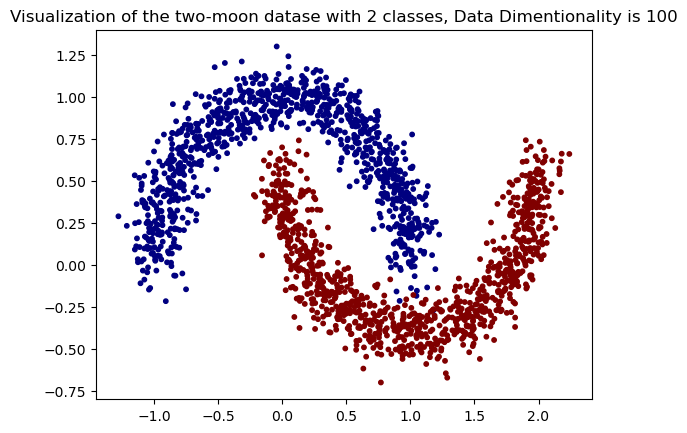

In [2]:
# Load raw data images
mat = scipy.io.loadmat('datasets/two_moons.mat')
X = mat['X']
n = X.shape[0]
d = X.shape[1]
Cgt = mat['Cgt']-1; Cgt=Cgt.squeeze()
nc = len(np.unique(Cgt))
print(n,d,nc)

# Plot
plt.figure(1)
size_vertex_plot = 10
plt.scatter(X[:,0], X[:,1], s=size_vertex_plot*np.ones(n), c=Cgt, cmap='jet')
plt.title('Visualization of the two-moon datase with 2 classes, Data Dimentionality is 100')
plt.show()


### Question 1: Determine the optimal value of k for the k-NN graph in the spectral NCut technique

What value of k gives the best clustering results?


k-NN graph with euclidean distance


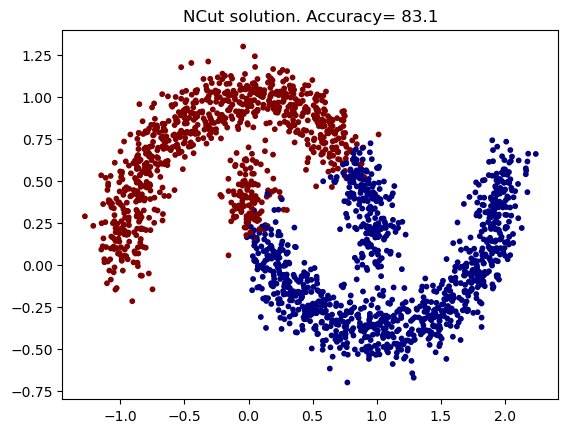

In [7]:
# Run NCut 
k = 10 # YOUR CODE HERE 
W = construct_knn_graph(X, k, 'euclidean')
C_ncut, _ = compute_ncut(W, Cgt, nc)

# Plot
plt.figure(2)
size_vertex_plot = 10
plt.scatter(X[:,0], X[:,1], s=size_vertex_plot*np.ones(n), c=C_ncut, cmap='jet')
plt.title('NCut solution. Accuracy= ' + 
          str(compute_purity(C_ncut, Cgt, nc))[:6] )
plt.show()


### Question 2: Evaluate the PCut technique with different values of k for the k-NN graph

What value ofk produces the most effective clustering result?

Additionally, what is the range of k that provides optimal clustering performance?


k-NN graph with euclidean distance


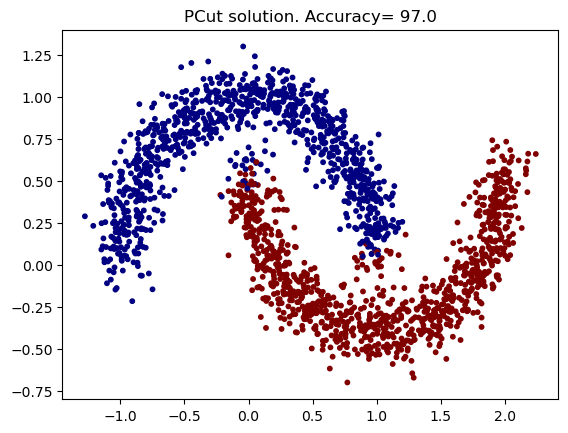

In [8]:
# Run PCut
k = 10 # YOUR CODE HERE 
W = construct_knn_graph(X, k, 'euclidean')
C_pcut, _ = compute_pcut(W, Cgt, nc, 2, 200)

# Plot
plt.figure(3)
size_vertex_plot = 10
plt.scatter(X[:,0], X[:,1], s=size_vertex_plot*np.ones(n), c=C_pcut, cmap='jet')
plt.title('PCut solution. Accuracy= ' + 
          str(compute_purity(C_pcut, Cgt, nc))[:6] )
plt.show()


### Comment: Compare the spectral NCut and PCut techniques on two real-world graphs

Run both the Spectral NCut and PCut techniques on two real-world graphs and compare their performance.


### USPS image graph

In [9]:
# Load USPS dataset
mat = scipy.io.loadmat('datasets/USPS.mat')
W = mat['W'] # 'scipy.sparse._csc.csc_matrix'
n = W.shape[0]
Cgt = mat['Cgt']-1; Cgt=Cgt.squeeze()
nc = len(np.unique(Cgt))
print(n,nc)


9298 10


In [13]:
Cncut, acc = compute_ncut(W,Cgt,nc)
print('Ncut accuracy =',acc)


Ncut accuracy = 73.52118735211873


In [12]:
Cpcut, acc = compute_pcut(W,Cgt,nc,5,10)
print('Pcut accuracy =',acc)


Pcut accuracy = 79.8558829855883


### MIREX music graph

In [14]:
# Load USPS dataset
mat = scipy.io.loadmat('datasets/MIREX.mat')
W = mat['W'] # 'scipy.sparse._csc.csc_matrix'
n = W.shape[0]
Cgt = mat['Cgt']-1; Cgt=Cgt.squeeze()
nc = len(np.unique(Cgt))
print(n,nc)


3090 10


In [15]:
Cncut, acc = compute_ncut(W,Cgt,nc)
print('Ncut accuracy =',acc)


Ncut accuracy = 39.15857605177994


In [16]:
Cpcut, acc = compute_pcut(W,Cgt,nc,0.5,400)
print('Pcut accuracy =',acc)


Pcut accuracy = 45.6957928802589


# Lecture : Graph Clustering

## Lab 06 : Louvain Algorithm -- Solution

### Xavier Bresson, Jiaming Wang


In [ ]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2025_codes/codes/03_Graph_Clustering'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    !pip install python-louvain==0.15 # install louvain
    

In [1]:
# Load libraries
import numpy as np
import scipy.io
%matplotlib inline
#%matplotlib notebook 
from matplotlib import pyplot
import matplotlib.pyplot as plt
import time
import sys; sys.path.insert(0, 'lib/')
from lib.utils import construct_kernel
from lib.utils import compute_kernel_kmeans_EM
from lib.utils import compute_kernel_kmeans_spectral
from lib.utils import compute_purity
from lib.utils import construct_knn_graph
from lib.utils import compute_ncut
from lib.utils import compute_pcut
from lib.utils import graph_laplacian
import warnings; warnings.filterwarnings("ignore")
import community # Louvain algorithm
import networkx as nx


### Two-moon dataset

n,d,nc: 2000 2 2


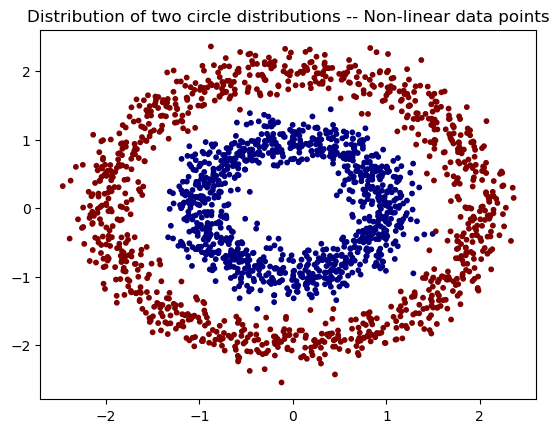

In [2]:
# Load two-circle dataset
mat = scipy.io.loadmat('datasets/two_circles.mat')
X = mat['X']
n = X.shape[0]
d = X.shape[1]
Cgt = mat['Cgt']-1; Cgt=Cgt.squeeze()
nc = len(np.unique(Cgt))
print('n,d,nc:',n,d,nc)

plt.figure(1)
size_vertex_plot = 10
plt.scatter(X[:,0], X[:,1], s=size_vertex_plot*np.ones(n), c=Cgt, cmap='jet')
plt.title('Distribution of two circle distributions -- Non-linear data points')
plt.show()


### Question 1: Evaluate the Louvain technique

How many "optimal" clusters does the Louvain method identify?

What is the clustering accuracy achieved by the Louvain solution?

Can you provide an explanation for the high accuracy?


k-NN graph with Zelnik-Perona technique
nb_data: 2000 , nb_clusters= 13
accuracy_louvain= 99.75  with nb_clusters= 13


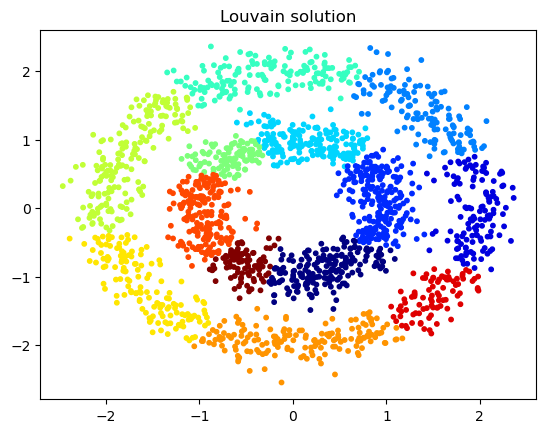

In [3]:
# Run Louvain algorithm
W = construct_knn_graph(X, 50, 'euclidean_zelnik_perona')
Wnx = nx.from_numpy_array(W)
partition = community.best_partition(Wnx)
nc_louvain = len(np.unique( [partition[nodes] for nodes in partition.keys()] ))
n = len(Wnx.nodes())
print('nb_data:', n , ', nb_clusters=', nc_louvain)

# Extract clusters
Clouv = np.zeros([n])
clusters = []
k = 0
for com in set(partition.values()):
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    Clouv[list_nodes] = k
    k += 1
    clusters.append(list_nodes)
    
# Accuracy
acc = compute_purity(Clouv,Cgt,nc_louvain)
print('accuracy_louvain=',acc,' with nb_clusters=',nc_louvain)

plt.figure(2)
size_vertex_plot = 10
plt.scatter(X[:,0], X[:,1], s=size_vertex_plot*np.ones(n), c=Clouv, cmap='jet')
plt.title('Louvain solution')
plt.show()


### USPS dataset

### Question 2: Compare the Louvain and spectral NCut solutions

Compare the clustering results of the Louvain method with those of the spectral NCut technique, using the same number of clusters.

How does the performance of the Spectral NCut technique change as the number of clusters increases?


In [4]:
# Load USPS dataset
mat = scipy.io.loadmat('datasets/USPS.mat')
W = mat['W']
n = W.shape[0]
Cgt = mat['Cgt']-1; Cgt=Cgt.squeeze()
nc = len(np.unique(Cgt))
print('n,nc:',n,nc)


n,nc: 9298 10


In [5]:
# Random partitionning
Crand = np.random.randint(0,nc,[n])
acc = compute_purity(Crand,Cgt,nc)
print('Random solution:', str(acc)[:5])

# Run NCut
Cncut, acc = compute_ncut(W,Cgt,nc) 
print('NCut solution:', str(acc)[:5])


Random solution: 16.73
NCut solution: 73.52


In [6]:
# Run Louvain
Wnx = nx.from_numpy_array(W.toarray())
partition = community.best_partition(Wnx)
nc_louvain = len(np.unique( [partition[nodes] for nodes in partition.keys()] ))
n = len(Wnx.nodes())
print('nb_data:', n , ', nb_clusters=', nc_louvain)

# Extract clusters
Clouv = np.zeros([n])
clusters = []
k = 0
for com in set(partition.values()):
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    Clouv[list_nodes] = k
    k += 1
    clusters.append(list_nodes)
    
# Accuracy
acc = compute_purity(Clouv,Cgt,nc_louvain)
print('Louvain solution ',str(acc)[:5],' with nb_clusters=',nc_louvain)


nb_data: 9298 , nb_clusters= 14
Louvain solution  95.75  with nb_clusters= 14


In [7]:
# Run NCut with the number of clusters found by Louvain
Cncut, acc = compute_ncut(W,Cgt,nc_louvain)
print('NCut solution:',str(acc)[:5],' with nb_clusters=',nc_louvain)


NCut solution: 87.34  with nb_clusters= 14
